In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
import numpy as np


db = mysql.connector.connect(host = "localhost",
                            username = "root",
                            password = "Omsairam@9969",
                            database = "Ecommerce")


cur = db.cursor()

In [5]:
# List all the unique cities where all the customers are located.


query = """ select distinct customer_city from customers """

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data)
df.head()

,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


In [6]:
# Count the number of orders placed in 2017.


query = """ select count(order_id) from orders where year(order_purchase_timestamp) = 2017 """

cur.execute(query)

data = cur.fetchall()

"total orders placed in 2017 are", data[0][0]

('total orders placed in 2017 are', 90202)

In [7]:
# Find the total sales per category


query = """ select upper(products.product_category) category, 
round(sum(payments.payment_value),2) sales
from products join order_items
on products.product_id = order_items.product_id
join payments 
on payments.order_id = order_items.order_id
group by category
"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ["Category", "Sales"])
df

,Category,Sales
0,PERFUMERY,4053909.28
1,FURNITURE DECORATION,11441411.13
2,TELEPHONY,3895056.41
3,BED TABLE BATH,13700429.37
4,AUTOMOTIVE,6818354.65
...,...,...
69,CDS MUSIC DVDS,9595.44
70,LA CUISINE,23308.24
71,FASHION CHILDREN'S CLOTHING,6285.36
72,PC GAMER,17395.44


In [8]:
# Calculate the percentage of orders that were paid in installments.


query = """ select (sum(case when payment_installments >= 1 then 1
else 0 end))/count(*)*100 from payments """

cur.execute(query)

data = cur.fetchall()

"the percentage of orders that were paid in installments is", data[0][0]

('the percentage of orders that were paid in installments is',
 Decimal('99.9981'))

<function matplotlib.pyplot.show(close=None, block=None)>

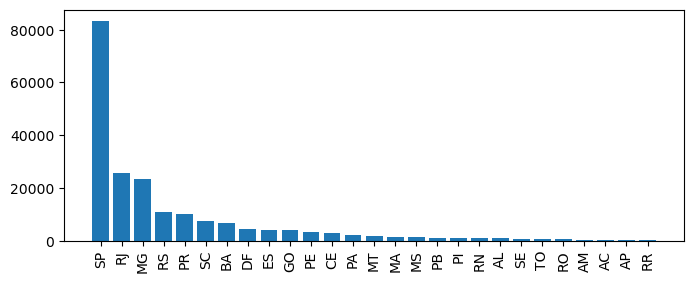

In [9]:
#Count the number of customers from each state. 


query = """ select customer_state, count(customer_id) 
from customers group by customer_state
"""


cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ["state", "customer_count"])
df = df.sort_values(by = "customer_count", ascending= False)

plt.figure(figsize = (8, 3))
plt.bar(df["state"], df["customer_count"])
plt.xticks(rotation = 90)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

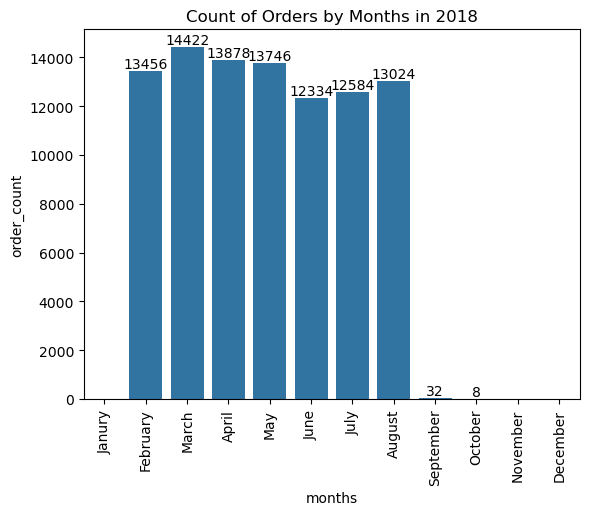

In [10]:
# Calculate the number of orders per month in 2018.


query = """ select monthname(order_purchase_timestamp) months, count(order_id) order_count
from orders where year(order_purchase_timestamp) = 2018
group by months
"""


cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ["months", "order_count"])
o = ["Janury", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]

ax = sns.barplot(x = df["months"], y = df["order_count"], data = df, order = o)
plt.xticks(rotation = 90)
ax.bar_label(ax.containers[0])
plt.title("Count of Orders by Months in 2018")

plt.show

In [11]:
# Find the average number of products per order, grouped by customer city. 


query = """with count_per_order as
(select orders.order_id, orders.customer_id, count(order_items.order_id) as oc
from orders join order_items
on orders.order_id = order_items.order_id
group by orders.order_id, orders.customer_id)

select customers.customer_city, round(avg(count_per_order.oc),2) average_orders
from customers join count_per_order
on customers.customer_id = count_per_order.customer_id
group by customers.customer_city order by average_orders desc
"""


cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data)
df.head(10)


,0,1
0,padre carvalho,28.00
1,celso ramos,26.00
2,datas,24.00
3,candido godoi,24.00
4,matias olimpio,20.00
5,cidelandia,16.00
6,curralinho,16.00
7,picarra,16.00
8,morro de sao paulo,16.00
9,teixeira soares,16.00


In [12]:
# Calculate the percentage of total revenue contributed by each product category. 


query = """ select upper(products.product_category) category,
round((sum(payments.payment_value)/(select sum(payment_value) from payments))*100,2) sales_percentage
from products join order_items
on products.product_id = order_items.product_id
join payments
on payments.order_id = order_items.order_id
group by category order by sales_percentage desc """ 


cur.execute(query)

df = pd.DataFrame(data,columns = ["Category", "percentage distribution"])
df



,Category,percentage distribution
0,padre carvalho,28.00
1,celso ramos,26.00
2,datas,24.00
3,candido godoi,24.00
4,matias olimpio,20.00
...,...,...
4105,sao mamede,4.00
4106,sambaiba,4.00
4107,japaratuba,4.00
4108,tuiuti,4.00


In [2]:
# Identify the correlation between product price and the number of times a product has been purchased. 


query = """select products.product_category,
count(order_items.product_id),
round(avg(order_items.price),2)
from products join order_items
on products.product_id = order_items.product_id
group by products.product_category """


cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["Category", "order_count", "price"])
df


arr1 = df["order_count"]
arr2 = df["price"]

a = np.corrcoef([arr1,arr2])
print("the correlation between price and the number of times a product has been purchased is", a[0][-1])


the correlation between price and the number of times a product has been purchased is -0.10631514167157562


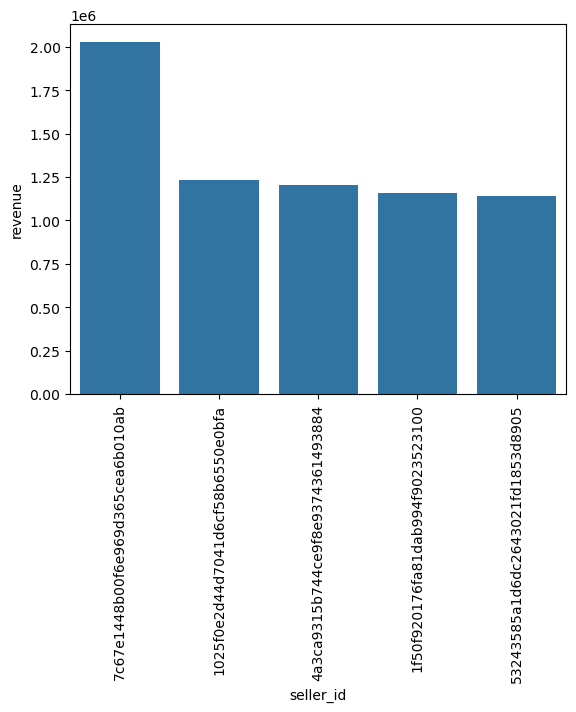

In [ ]:
# Calculate the total revenue generated by each seller, and rank them by revenue.


query = """ select *, dense_rank() over(order by revenue desc) as rn from
(select order_items.seller_id, sum(payments.payment_value)
revenue from order_items join payments
on order_items.order_id = payments.order_id
group by order_items.seller_id) as a """


cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["seller_id", "revenue", "rank"])
df = df.head()
sns.barplot(x = "seller_id", y = "revenue", data = df)
plt.xticks(rotation = 90)
plt.show()



In [ ]:
# Calculate the moving average of order values for each values for each customer over their order history.


query = """ select customer_id, order_purchase_timestamp,
avg(payment) over (partition by customer_id order by order_purchase_timestamp
rows between 2 preceding and current row) as mov_avg
from 
(select orders.customer_id, orders.order_purchase_timestamp,
payments.payment_value as payment
from payments join orders
on payments.order_id = orders.order_id) as a """


cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data)
df

,0,1,2
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.739998
1,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.739998
2,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.739998
3,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.739998
4,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.410004
...,...,...,...
415539,ffffa3172527f765de70084a7e53aae8,2017-09-02 11:53:32,45.500000
415540,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.370001
415541,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.370001
415542,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.370001


In [4]:
# Calculate the cumulative sales per month for each year.


query = """ select years, months, payment, sum(payment)
over(order by years, months) cumulative_sales from
(select year(orders.order_purchase_timestamp) as years,
monthname(orders.order_purchase_timestamp) as months,
round(sum(payments.payment_value),2) as payment from orders join payments
on orders.order_id = payments.order_id
group by years, months order by years, months) as a """


cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data)
df

,0,1,2,3
0,2016,December,78.48,78.48
1,2016,October,236361.92,236440.40
2,2016,September,1008.96,237449.36
3,2017,April,1671152.12,1908601.48
4,2017,August,2697585.28,4606186.76
5,2017,December,3513605.92,8119792.68
6,2017,February,1167632.04,9287424.72
7,2017,January,553952.16,9841376.88
8,2017,July,2369531.68,12210908.56
9,2017,June,2045105.52,14256014.08


In [14]:
# Calculate the year-over-year growth rate of total sales.



query = """ with a as(select year(orders.order_purchase_timestamp) as years,
round(sum(payments.payment_value),2) as payment from orders join payments
on orders.order_id = payments.order_id
group by years order by years)

select years, (payment - lag(payment, 1) over(order by years))/
lag(payment, 1) over(order by years) * 100 from a """

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["years", "yoy % growth"])
df

,years,yoy % growth
0,2016,NaN
1,2017,12112.703757
2,2018,20.000924


In [15]:
# Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase. 


query = """ with a as (select customers.customer_id,
min(orders.order_purchase_timestamp) first_order
from customers join orders
on customers.customer_id = orders.customer_id
group by customers.customer_id),

b as (select a.customer_id, count(distinct orders.order_purchase_timestamp) next_order
from a join orders
on orders.customer_id = a.customer_id
and orders.order_purchase_timestamp > first_order
and orders.order_purchase_timestamp < 
date_add(first_order, interval 1 month) 
group by a.customer_id) 

select 100 * (count(distinct a.customer_id)/ count(distinct b.customer_id)) 
from a left join b 
on a.customer_id = b.customer_id """

cur.execute(query)
data = cur.fetchall()

data

# Since there are no customers from the dataset that made another purchase within 6 months of their first purchase therefore the value for retention rate of customers is 0 and the end result of the code is None

[(None,)]

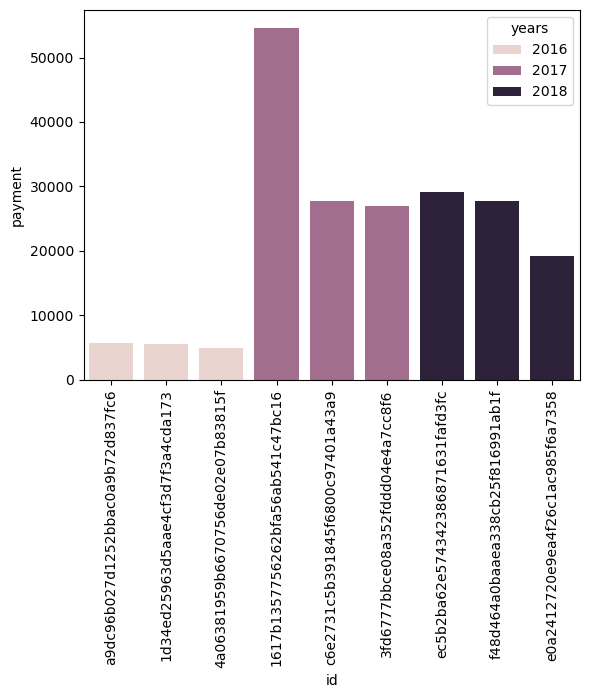

In [22]:
# Identify the top 3 customers who spent the most money in each year. 


query = """ select years, customer_id, payment, d_rank
from 
(select year(orders.order_purchase_timestamp) years,
orders.customer_id,
sum(payments.payment_value) payment,
dense_rank() over(partition by year(orders.order_purchase_timestamp)
order by sum(payments.payment_value) desc) d_rank 
from orders join payments 
on payments.order_id = orders.order_id 
group by year(orders.order_purchase_timestamp),
orders.customer_id) as a
where d_rank <= 3 """

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["years", "id", "payment", "rank"])
sns.barplot(x = "id", y = "payment", data = df, hue = "years")
plt.xticks(rotation = 90)
plt.show()
